In [7]:
from transformers.utils import TRANSFORMERS_CACHE
print(TRANSFORMERS_CACHE)

C:\Users\Han\.cache\huggingface\hub


In [ ]:
import pandas as pd
import numpy as np
import jieba
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [34]:
conts = pd.read_json('../../Data/processed/contents_cooked_semantic.json', lines=True)

# 定义核心关键词
CORE_KEYWORDS = {
    '鲜芋仙', 'Meet Fresh', 'MeetFresh', '台湾美食', '甜品',
    '芋圆', 'taro', '仙草', 'grass jelly', '奶茶', 'milk tea',
    '豆花', 'tofu pudding', '奶刨冰', 'milked shaved ice', 
    '红豆汤', 'purple rice soup', '紫米粥', 'red bean soup',
    '2001 Coit Rd', 'Park Pavillion Center', '(972) 596-6088',
    '刘一手', '锅底', '火锅',
}

In [35]:
conts.columns

Index(['note_id', 'user_id', 'title', 'note_body', 'tag_list', 'image_count',
       'content_type_video', 'hot_note', 'post_time', 'last_update_time',
       'scraped_time', 'elapsed_time', 'liked_count', 'collected_count',
       'comment_count', 'share_count', 'interaction_count',
       'semantic_proc_text', 'originality'],
      dtype='object')

In [53]:
# =============================================
# 1. MODEL LOADING FUNCTIONS
# =============================================

def load_models():
    """加载所需的各种模型"""
    models = {}
    
    # 原创性检测模型
    models['tfidf'] = TfidfVectorizer(max_features=6000)
    models['simcse'] = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    
    # 情感分析模型
    models['bert_tokenizer'] = BertTokenizer.from_pretrained("bert-base-chinese")
    models['bert_model'] = BertModel.from_pretrained("bert-base-chinese")
    models['bert_model'].eval()
    
    return models

# =============================================
# 2. PREPROCESSING FUNCTIONS
# =============================================

def preprocess_data(df):
    """数据预处理，创建用户级评分DataFrame"""
    df = df.copy()
    
    # 用户笔记映射
    user_notes = df.groupby('user_id')['semantic_proc_text'].apply(list)
    
    # 创建包含所有用户ID的DataFrame（dim3_score）
    unique_users = df['user_id'].unique()
    dim3_score = pd.DataFrame({'user_id': unique_users, 'originality_score': 0
                               , 'vertical_score': 0, 'sentiment_score': 0
                               , 'keyword_score': 0, 'dim3_score': 0})
    
    return df, user_notes, dim3_score

In [85]:
def calculate_creator_originality(df, dim3_score, models):
    """
    创作者原创性评分计算, 分为内部多样性和外部原创性两个维度
    使用完全不抽样的方式：使用创作者的全部笔记进行计算
    
    1. 内部多样性：使用TF-IDF和SimCSE计算创作者所有笔记之间的相似度
    2. 外部原创性：使用SimCSE计算创作者之间的相似度
    
    Args:
        df (pd.DataFrame): 输入数据框，包含用户笔记和其他信息
        dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
        models (dict): 包含所需模型的字典
    
    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print("  - 计算创作者原创性...")
    
    # 按创作者分组准备数据
    user_texts = df.groupby('user_id')['semantic_proc_text'].apply(list).to_dict()
    user_to_indices = df.groupby('user_id').apply(lambda x: x.index.tolist()).to_dict()
    
    # 存储各项指标
    internal_diversity = {}
    external_originality = {}
    
    # 1. 计算内部多样性（同时使用TF-IDF和SimCSE）
    print("  - 计算创作者内部多样性...")
    for user_id, texts in user_texts.items():
        indices = user_to_indices[user_id]
        
        # 处理笔记数量少的情况
        if len(texts) < 20:  # 少于20篇
            internal_diversity[user_id] = 0.8  # 默认中上多样性分数
            continue
        
        print(f"用户 {user_id}: 使用全部 {len(texts)} 篇笔记计算内部多样性")
        
        # 使用所有文本 - 不抽样
        all_texts = texts
            
        # 双方法计算多样性
        # 1. TF-IDF计算
        tfidf = models['tfidf'].fit_transform(all_texts)
        tfidf_sim = cosine_similarity(tfidf)
        np.fill_diagonal(tfidf_sim, 0)
        tfidf_avg_sim = np.mean(tfidf_sim)
        
        # 2. SimCSE计算
        embeddings = models['simcse'].encode(all_texts, show_progress_bar=False)
        emb_sim = cosine_similarity(embeddings)
        np.fill_diagonal(emb_sim, 0)
        emb_avg_sim = np.mean(emb_sim)
        
        # 结合两种方法（取平均相似度）
        avg_sim = 0.5 * tfidf_avg_sim + 0.5 * emb_avg_sim
        
        # 转换为内部多样性评分
        internal_diversity[user_id] = 1 - avg_sim
    
    # 2. 计算外部原创性
    print("  - 计算创作者之间的原创性差异...")
    
    # 为每个创作者构建代表性文本集 - 仍使用头部和热门的抽样策略，避免计算过度庞大
    representative_texts = {}
    for user_id in user_texts.keys():
        # 获取该创作者的所有笔记索引
        indices = user_to_indices[user_id]
        
        # 提取头部笔记（最新的10篇）
        top_indices = indices[:min(10, len(indices))]
        
        # 获取热门笔记
        hot_indices = df.loc[indices].query("hot_note == 1").index.tolist()
        if hot_indices and len(hot_indices) > 30:
            import random
            hot_indices = random.sample(hot_indices, 30)  # 最多选30篇热门
        
        # 如果头部+热门笔记总数少于40，补充随机笔记
        if len(top_indices) + len(hot_indices) < 40 and len(indices) > len(top_indices) + len(hot_indices):
            remaining_indices = [i for i in indices if i not in top_indices and i not in hot_indices]
            import random
            random_count = min(40 - len(top_indices) - len(hot_indices), len(remaining_indices))
            random_indices = random.sample(remaining_indices, random_count)
        else:
            random_indices = []
        
        # 合并所有选定的索引
        selected_indices = list(set(top_indices + hot_indices + random_indices))
        
        # 获取对应的文本
        representative_texts[user_id] = df.loc[selected_indices, 'semantic_proc_text'].tolist() if selected_indices else []
    
    # 对代表性文本进行编码
    print("  - 对代表性文本进行语义编码...")
    user_embeddings = {}
    all_rep_texts = []
    user_mapping = []
    
    for user_id, texts in representative_texts.items():
        if not texts:  # 防止空文本列表
            continue
        all_rep_texts.extend(texts)
        user_mapping.extend([user_id] * len(texts))
    
    # 只对代表性文本使用SimCSE
    if all_rep_texts:
        embeddings = models['simcse'].encode(all_rep_texts, show_progress_bar=True)
        
        # 按创作者聚合
        for i, user_id in enumerate(user_mapping):
            if user_id not in user_embeddings:
                user_embeddings[user_id] = []
            user_embeddings[user_id].append(embeddings[i])
    
    # 计算创作者级平均表示
    for user_id, embs in user_embeddings.items():
        if embs:  # 确保有嵌入向量
            user_embeddings[user_id] = np.mean(embs, axis=0)
    
    # 计算创作者间相似度
    user_ids = list(user_embeddings.keys())
    
    for i, user_id in enumerate(user_ids):
        user_emb = user_embeddings[user_id]
        similarities = []
        
        for j, other_id in enumerate(user_ids):
            if i != j:
                other_emb = user_embeddings[other_id]
                sim = cosine_similarity([user_emb], [other_emb])[0][0]
                similarities.append(sim)
        
        # 外部原创性
        if similarities:
            # 不仅考虑平均相似度，也考虑最大相似度（最大相似度权重更高）
            avg_sim = np.mean(similarities)
            max_sim = np.max(similarities)
            weighted_sim = 0.6 * avg_sim + 0.4 * max_sim
            external_originality[user_id] = 1 - weighted_sim
        else:
            external_originality[user_id] = 0.9  # 默认高的原创性
    
    # 3. 结合两个维度并应用分数映射
    print("  - 组合评分并应用分布校正...")
    user_originality = {}
    
    for user_id in user_texts.keys():
        int_div = internal_diversity.get(user_id, 0.5)
        ext_orig = external_originality.get(user_id, 0.5)
        
        # 组合分数
        combined_raw = 0.5 * int_div + 0.5 * ext_orig
        
        # Sigmoid映射到0-25区间
        user_originality[user_id] = 25 / (1 + np.exp(-8 * (combined_raw - 0.5)))
    
    # 分布校正
    scores = np.array(list(user_originality.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    if std < 4:  # 分布过于集中
        # 双边拉伸但保持相对关系
        stretch_factor = 5 / std if std > 0 else 1.5
        for user_id in user_originality:
            diff = user_originality[user_id] - mean
            user_originality[user_id] = np.clip(mean + diff * stretch_factor, 0, 25)
            
            # 软化极端值
            if user_originality[user_id] > 23:
                user_originality[user_id] = 23 + (user_originality[user_id] - 23) * 0.5
            elif user_originality[user_id] < 2:
                user_originality[user_id] = 2 * (user_originality[user_id] / 2)
    
    # 直接更新dim3_score的originality_score列
    for user_id, score in user_originality.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'originality_score'] = score
    
    return dim3_score

In [56]:
# 计算创作者原创性评分
models = load_models()
df, user_notes, dim3_score = preprocess_data(conts)

  - 计算创作者原创性...
  - 计算创作者内部多样性...
用户 54d82c482e1d9366ebfc8ce5: 使用全部 270 篇笔记计算内部多样性


C:\Users\Han\AppData\Local\Temp\ipykernel_1228\361450642.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_to_indices = df.groupby('user_id').apply(lambda x: x.index.tolist()).to_dict()


用户 5530f8642e1d9365fa9a29fb: 使用全部 287 篇笔记计算内部多样性
用户 55481451b203d97e86008c02: 使用全部 179 篇笔记计算内部多样性
用户 556f1983f5a26347140b104b: 使用全部 560 篇笔记计算内部多样性
用户 558a4a065894460336de85bf: 使用全部 510 篇笔记计算内部多样性
用户 55f2f7e3f5a2635bd2fac7b5: 使用全部 324 篇笔记计算内部多样性
用户 5649379603eb842b7ed00477: 使用全部 66 篇笔记计算内部多样性
用户 564d4a9167bc65539cd768d4: 使用全部 65 篇笔记计算内部多样性
用户 568b2f486a6a6962f22d07ba: 使用全部 82 篇笔记计算内部多样性
用户 56ada7e482ec39541becb6ff: 使用全部 186 篇笔记计算内部多样性
用户 56b2e6dae4251d7f46ab14e3: 使用全部 137 篇笔记计算内部多样性
用户 570b4b5a1c07df4cfd6ccbf0: 使用全部 482 篇笔记计算内部多样性
用户 576d3bde82ec3952ff40c5e1: 使用全部 146 篇笔记计算内部多样性
用户 576e5cc95e87e72f9801db4d: 使用全部 33 篇笔记计算内部多样性
用户 57a142546a6a695a454d664e: 使用全部 76 篇笔记计算内部多样性
用户 57edc02550c4b47c9e876daf: 使用全部 339 篇笔记计算内部多样性
用户 57f5f8b06a6a6963e65ffc89: 使用全部 141 篇笔记计算内部多样性
用户 57fdaead82ec3961690f6b93: 使用全部 187 篇笔记计算内部多样性
用户 57ffbca35e87e76f746d9a64: 使用全部 35 篇笔记计算内部多样性
用户 5801c70f6a6a697bad62b653: 使用全部 110 篇笔记计算内部多样性
用户 580c368650c4b44811e07ff8: 使用全部 70 篇笔记计算内部多样性
用户 5859b26f6a6a6967855d7c65

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

  - 组合评分并应用分布校正...


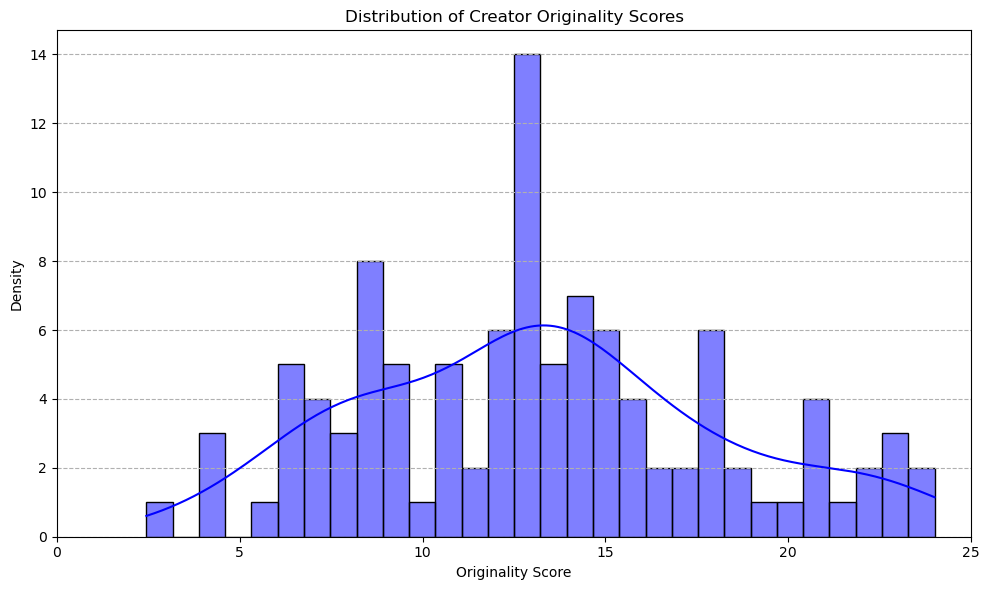

count    106.000000
mean      13.191597
std        4.923293
min        2.443973
25%        9.113296
50%       13.080882
75%       16.070779
max       24.000000
Name: originality_score, dtype: float64

In [86]:
# 获取创作者维度的原创性评分
dim3_score = calculate_creator_originality(df, dim3_score, models)
# plot the histogram of dim3_score
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['originality_score'], bins=30, kde=True, color='blue', stat='count')
plt.title('Distribution of Creator Originality Scores')
plt.xlabel('Originality Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_score_distribution.png')
plt.show()

# get the statistics of dim3_score.originality_score
dim3_score['originality_score'].describe()

In [78]:
def calculate_vertical_score(df, dim3_score, 
                             target_tags={'美食', '探店', '火锅', '甜品',
                                           '奶茶', '外卖', '中餐', '小吃',
                                            'food'}):
    """
    计算垂直领域得分
    基于创作者笔记中包含目标标签子字符串的比例
    
    Args:
        df (pd.DataFrame): 输入数据框，包含笔记信息
        dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
        target_tags (set): 目标标签集合
    
    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print(f"  - 计算垂直领域分数... (目标标签: {target_tags})")
    
    # 检查每个笔记的标签列表是否包含任何目标标签作为子字符串
    def has_target_tag(tags):
        if not tags or pd.isna(tags):
            return 0
        
        # 将用户标签拆分为列表
        user_tags = str(tags).split(',')
        
        # 检查每个用户标签是否包含任何目标标签作为子字符串
        for user_tag in user_tags:
            user_tag = user_tag.strip().lower()  # 移除前后空格并转为小写
            for target_tag in target_tags:
                target_tag = str(target_tag).lower()  # 转为小写以进行不区分大小写的比较
                if target_tag in user_tag:  # 如果目标标签是用户标签的子字符串
                    return 1
                    
        return 0
    
    # 添加标记列
    df['has_target_tag'] = df['tag_list'].apply(has_target_tag)
    
    # 按创作者分组计算包含目标标签的笔记比例
    user_vertical_scores = {}
    
    for user_id, group in df.groupby('user_id'):
        # 计算包含目标标签的笔记比例
        target_tag_ratio = group['has_target_tag'].mean()
        
        # 输出调试信息
        print(f"用户 {user_id}: {len(group)} 篇笔记, {target_tag_ratio:.1%} 包含目标标签")
        
        # 增强分数效果，使用非线性映射
        # 使用幂函数提升低比例的得分
        adjusted_ratio = target_tag_ratio ** 0.7  # 使用0.7次幂拉伸低分区间
        
        # 转换为0-25分
        raw_score = adjusted_ratio * 25
        user_vertical_scores[user_id] = raw_score
    
    # 应用分数分布校正
    scores = np.array(list(user_vertical_scores.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    print(f"  - 原始垂直领域分数: 均值={mean:.2f}, 标准差={std:.2f}")
    
    # 分布校正 - 提高基础分
    base_boost = 5.0  # 基础分提升
    for user_id in user_vertical_scores:
        score = user_vertical_scores[user_id]
        if score > 0:  # 只要有匹配就给一个基础分
            user_vertical_scores[user_id] = min(25, base_boost + score)
    
    # 再次拉伸分布
    scores = np.array(list(user_vertical_scores.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    if std < 4:  # 分布过于集中
        # 双边拉伸但保持相对关系
        stretch_factor = 5 / std if std > 0 else 1.5
        for user_id in user_vertical_scores:
            diff = user_vertical_scores[user_id] - mean
            user_vertical_scores[user_id] = np.clip(mean + diff * stretch_factor, 0, 25)
            
            # 软化极端值
            if user_vertical_scores[user_id] > 23:
                user_vertical_scores[user_id] = 23 + (user_vertical_scores[user_id] - 23) * 0.5
            elif user_vertical_scores[user_id] < 2:
                user_vertical_scores[user_id] = 2 * (user_vertical_scores[user_id] / 2)
    
    # 校正后的统计
    corrected_scores = np.array(list(user_vertical_scores.values()))
    corrected_mean = np.mean(corrected_scores)
    corrected_std = np.std(corrected_scores)
    print(f"  - 校正后垂直领域分数: 均值={corrected_mean:.2f}, 标准差={corrected_std:.2f}")
    
    # 更新dim3_score的vertical_score列
    for user_id, score in user_vertical_scores.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'vertical_score'] = score
    
    # 移除临时列
    if 'has_target_tag' in df.columns:
        df.drop(columns=['has_target_tag'], inplace=True)
    
    return dim3_score

  - 计算垂直领域分数... (目标标签: {'甜品', '中餐', '探店', 'food', '美食', '小吃', '火锅', '奶茶', '外卖'})
用户 54d82c482e1d9366ebfc8ce5: 270 篇笔记, 62.6% 包含目标标签
用户 5530f8642e1d9365fa9a29fb: 287 篇笔记, 60.6% 包含目标标签
用户 55481451b203d97e86008c02: 179 篇笔记, 67.6% 包含目标标签
用户 556f1983f5a26347140b104b: 560 篇笔记, 28.0% 包含目标标签
用户 558a4a065894460336de85bf: 510 篇笔记, 0.6% 包含目标标签
用户 55f2f7e3f5a2635bd2fac7b5: 324 篇笔记, 5.2% 包含目标标签
用户 5649379603eb842b7ed00477: 66 篇笔记, 59.1% 包含目标标签
用户 564d4a9167bc65539cd768d4: 65 篇笔记, 1.5% 包含目标标签
用户 568b2f486a6a6962f22d07ba: 82 篇笔记, 4.9% 包含目标标签
用户 56ada7e482ec39541becb6ff: 186 篇笔记, 39.8% 包含目标标签
用户 56b2e6dae4251d7f46ab14e3: 137 篇笔记, 14.6% 包含目标标签
用户 570b4b5a1c07df4cfd6ccbf0: 482 篇笔记, 22.6% 包含目标标签
用户 576d3bde82ec3952ff40c5e1: 146 篇笔记, 54.1% 包含目标标签
用户 576e5cc95e87e72f9801db4d: 33 篇笔记, 54.5% 包含目标标签
用户 57a142546a6a695a454d664e: 76 篇笔记, 2.6% 包含目标标签
用户 57edc02550c4b47c9e876daf: 339 篇笔记, 7.1% 包含目标标签
用户 57f5f8b06a6a6963e65ffc89: 141 篇笔记, 54.6% 包含目标标签
用户 57fdaead82ec3961690f6b93: 187 篇笔记, 27.8% 包含目标标签
用户 57ffbca35

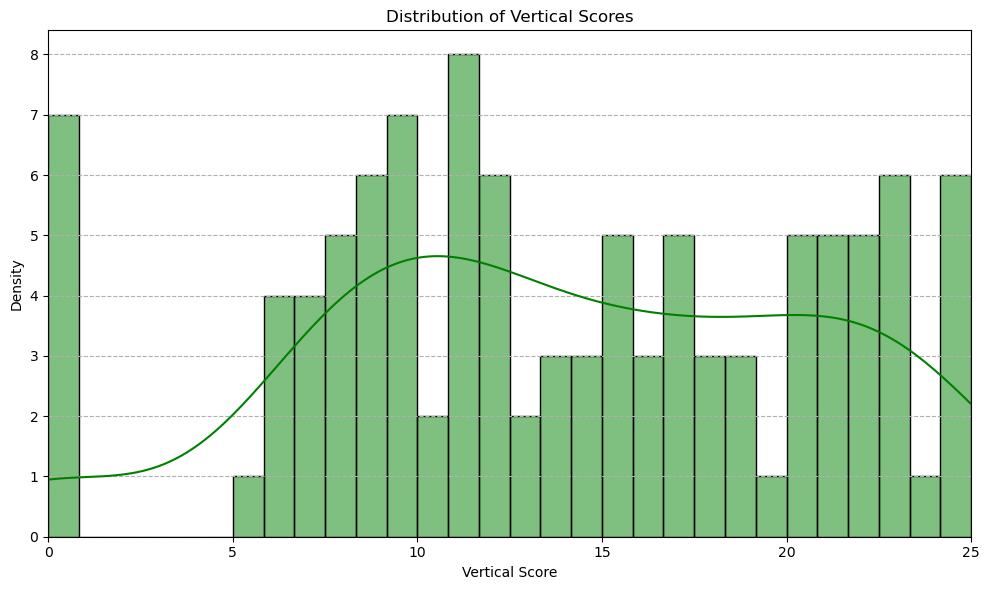

count    106.000000
mean      14.008451
std        6.742616
min        0.000000
25%        9.051632
50%       13.694353
75%       20.120305
max       25.000000
Name: vertical_score, dtype: float64

In [87]:
# 获取创作者维度的垂直领域评分
dim3_score = calculate_vertical_score(df, dim3_score)

# plot the histogram of dim3_score.vertical_score
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['vertical_score'], bins=30, kde=True, color='green', stat='count')
plt.title('Distribution of Vertical Scores')
plt.xlabel('Vertical Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_vertical_score_distribution.png')
plt.show()

# get the statistics of dim3_score.vertical_score
dim3_score['vertical_score'].describe()

In [88]:
def calculate_sentiment_score(df, dim3_score, models):
    """
    计算情感强度得分，按用户分组后批量处理整合BERT情感分析、时间衰减和分布校正

    Args:
        df (pd.DataFrame): 输入数据框，包含用户笔记
        dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
        models (dict): 包含所需模型的字典

    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print("  - 计算情感强度得分...")
    
    # 按用户分组准备数据，只保留必要字段减少内存占用
    user_data = {}
    for user_id, group in df.groupby('user_id'):
        user_data[user_id] = {
            'texts': group['semantic_proc_text'].tolist(),
            'times': group['elapsed_time'].tolist()
        }
    
    # 按用户计算情感得分
    user_sentiment_scores = {}
    
    for user_id, data in user_data.items():
        texts = data['texts']
        times = data['times']
        
        # 跳过空文本
        if not texts:
            user_sentiment_scores[user_id] = 0
            continue
        
        # 批量处理文本 (每批最多50条，避免内存溢出)
        batch_size = 50
        sentiment_values = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # 截取长文本，避免处理过长的文本
            truncated_texts = [t[:512] if t else "" for t in batch_texts]
            
            # BERT批量情感计算
            inputs = models['bert_tokenizer'](
                truncated_texts, 
                padding=True, 
                truncation=True, 
                return_tensors="pt"
            )
            
            with torch.no_grad():
                outputs = models['bert_model'](**inputs)
                
            # 提取每个文本的情感值 (使用平均池化)
            batch_values = outputs.last_hidden_state.mean(dim=1).mean(dim=1).numpy()
            sentiment_values.extend(batch_values.tolist())
        
        # 应用时间衰减
        decay = np.exp(-0.05 * np.array(times) / 7)
        weighted_values = np.array(sentiment_values) * decay
        
        # 计算用户情感平均值
        avg_sentiment = np.mean(weighted_values)
        
        # 强化情感信号 (使用指数映射拉伸分数分布)
        # 这将使得低值也能得到合理分数，同时高值能获得更高分数
        base_score = 5.0  # 基础分
        exp_factor = 15.0  # 指数因子
        
        # 使用指数变换提升分数并拉开差距
        user_sentiment_scores[user_id] = base_score + exp_factor * (avg_sentiment ** 0.5)
    
    # 2. 应用分数分布校正 - 更强力的校正确保分布在0-25范围
    print("  - 校正情感分数分布...")
    scores = np.array(list(user_sentiment_scores.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    print(f"  - 变换后基础情感分数: 均值={mean:.2f}, 标准差={std:.2f}")
    
    # 双边拉伸 - 使用较大的拉伸因子
    stretch_factor = 8.0 / max(std, 0.1)  # 更激进的拉伸确保分布宽泛
    
    for user_id in user_sentiment_scores:
        diff = user_sentiment_scores[user_id] - mean
        stretched_score = mean + diff * stretch_factor
        
        # 确保分数在0-25范围内
        user_sentiment_scores[user_id] = np.clip(stretched_score, 0, 25)
        
        # 额外处理高分区间，确保高分也有足够数量
        if user_sentiment_scores[user_id] > mean + std:
            boost_factor = 1.3  # 高分提升因子
            headroom = 25 - user_sentiment_scores[user_id]
            user_sentiment_scores[user_id] += headroom * 0.4 * boost_factor
            user_sentiment_scores[user_id] = min(25, user_sentiment_scores[user_id])
    
    # 校正后的统计
    corrected_scores = np.array(list(user_sentiment_scores.values()))
    corrected_mean = np.mean(corrected_scores)
    corrected_std = np.std(corrected_scores)
    print(f"  - 校正后情感分数: 均值={corrected_mean:.2f}, 标准差={corrected_std:.2f}")
    
    # 3. 更新dim3_score的sentiment_score列
    for user_id, score in user_sentiment_scores.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'sentiment_score'] = score
    
    return dim3_score

In [ ]:
# 获取创作者维度的情感评分
dim3_score = calculate_sentiment_score(df, dim3_score, models)

# plot the histogram of dim3_score.sentiment_score
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['sentiment_score'], bins=30, kde=True, color='gold', stat='count')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_sentiment_score_distribution.png')
plt.show()

# get the statistics of dim3_score.sentiment_score
dim3_score['sentiment_score'].describe()

  - 计算情感强度得分...
  - 计算笔记级情感值...
  - 应用时间衰减...
  - 聚合用户级情感分数...
  - 校正情感分数分布...
  - 原始情感分数: 均值=-0.01, 标准差=0.01
  - 校正后情感分数: 均值=1.62, 标准差=1.37


C:\Users\Han\AppData\Local\Temp\ipykernel_1228\389505752.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.5363623095784957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dim3_score.loc[idx, 'sentiment_score'] = score


In [ ]:




# =============================================
# 3. INDIVIDUAL SCORING FUNCTIONS
# =============================================






def calculate_keyword_count(df, core_keywords):
    """计算关键词覆盖得分"""
    # 1. 创建关键词匹配模式
    pattern = re.compile('|'.join(re.escape(kw) for kw in core_keywords), flags=re.IGNORECASE)
    
    # 2. 计算关键词数量
    df['kw_count'] = df['semantic_proc_text'].apply(
        lambda x: len(pattern.findall(str(x)))
    )
    
    return df

def calculate_single_keyword_score(df):
    """计算单篇关键词得分"""
    # 1. 时间衰减系数
    decay = np.exp(-0.05 * df['elapsed_days'] / 7)
    
    # 2. 基于关键词数量和时间衰减的单篇得分
    df['single_score'] = np.maximum(1, df['kw_count'] / 5) * decay
    
    return df

def calculate_user_keyword_score(df):
    """计算用户级关键词得分"""
    # 定义用户维度聚合函数
    def user_keyword_aggregation(group):
        # 基准值计算
        p90 = group['single_score'].quantile(0.9) if len(group) > 1 else group['single_score'].max()
        p90 = max(p90, 0.0001)  # 防止除零
        
        cover_rate = (group['kw_count'] > 0).mean()
        
        # 计算综合得分
        score = (group['single_score'].mean() / p90 * 0.7 + cover_rate / 0.5 * 0.3) * 25
        return pd.Series({'keyword': min(score, 25)})
    
    # 计算用户级得分
    user_scores = df.groupby('user_id').apply(user_keyword_aggregation)
    
    # 合并回原数据
    df = df.merge(user_scores, on='user_id')
    
    return df

# =============================================
# 4. MAIN ORCHESTRATION FUNCTION
# =============================================

def calculate_all_scores(df, core_keywords):
    """主流程：计算所有内容分数"""
    print("1. 加载模型...")
    models = load_models()
    
    print("2. 预处理数据...")
    df, user_notes = preprocess_data(df)
    
    print("3. 计算原创性分数...")
    df = calculate_originality_score(df, models)
    
    print("4. 计算垂直领域分数...")
    df = calculate_vertical_score(df)
    
    print("5. 计算情感强度分数...")
    df = calculate_sentiment_score(df, models)
    
    print("6. 计算关键词覆盖分数...")
    df = calculate_keyword_count(df, core_keywords)
    df = calculate_single_keyword_score(df)
    df = calculate_user_keyword_score(df)
    
    print("所有分数计算完成!")
    return df

In [14]:
# 示例使用
df = pd.read_json('../../Data/processed/contents_cooked_semantic.json', lines=True)

# 定义核心关键词
CORE_KEYWORDS = {
    '鲜芋仙', 'Meet Fresh', 'MeetFresh', '台湾美食', '甜品',
    '芋圆', 'taro', '仙草', 'grass jelly', '奶茶', 'milk tea',
    '豆花', 'tofu pudding', '奶刨冰', 'milked shaved ice', 
    '红豆汤', 'purple rice soup', '紫米粥', 'red bean soup',
    '2001 Coit Rd', 'Park Pavillion Center', '(972) 596-6088',
    '刘一手', '锅底', '火锅',
}

# 计算所有分数
scored_df = calculate_all_scores(df, CORE_KEYWORDS)

# 查看结果
print(scored_df[['user_id', 'originality', 'vertical', 'sentiment', 'keyword']].head())

1. 加载模型...
2. 预处理数据...
3. 计算原创性分数...


Batches:   0%|          | 0/499 [00:00<?, ?it/s]

h:\Software\miniforge3\envs\torch\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


4. 计算垂直领域分数...
5. 计算情感强度分数...
6. 计算关键词覆盖分数...
所有分数计算完成!
                    user_id   originality  vertical  sentiment    keyword
0  576d3bde82ec3952ff40c5e1 -5.551115e-15       0.0       25.0  13.714851
1  576d3bde82ec3952ff40c5e1  2.775558e-15       0.0       25.0  13.714851
2  576d3bde82ec3952ff40c5e1  0.000000e+00       0.0       25.0  13.714851
3  576d3bde82ec3952ff40c5e1 -2.980232e-06       0.0       25.0  13.714851
4  576d3bde82ec3952ff40c5e1 -2.980232e-06       0.0       25.0  13.714851


C:\Users\Han\AppData\Local\Temp\ipykernel_1228\3016393291.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_scores = df.groupby('user_id').apply(user_keyword_aggregation)


In [19]:
scored_df.originality.value_counts()

originality
 0.000000e+00    5811
-5.551115e-15    3421
-2.980232e-06    2715
-5.960464e-06    2087
 2.980232e-06     393
-1.110223e-14     332
-8.940697e-06     331
 5.960464e-06     216
-1.192093e-05     141
 1.490116e-06     129
 4.470348e-06     101
 2.775558e-15      66
 5.551115e-15      47
 8.940697e-06      46
 7.450581e-06      34
 8.326673e-15      22
 1.043081e-05      16
-1.665335e-14      10
 1.192093e-05       9
-1.490116e-05       5
 1.387779e-14       2
 1.665335e-14       2
 1.110223e-14       2
 1.490116e-05       2
 1.341105e-05       1
Name: count, dtype: int64

In [20]:
scored_df.vertical.value_counts()

vertical
0.0     15213
5.0       633
10.0       91
15.0        4
Name: count, dtype: int64

In [17]:
scored_df.sentiment.value_counts()

sentiment
25.000000    14347
0.000000       353
9.295962         2
2.022227         1
12.356882        1
             ...  
0.915073         1
0.854627         1
0.579986         1
0.831711         1
0.000066         1
Name: count, Length: 1242, dtype: int64

In [18]:
scored_df.keyword.value_counts()

keyword
5.318313     781
6.726553     737
8.741024     600
6.084625     560
6.085666     510
            ... 
16.671688     21
16.424657     15
13.452744     14
15.691151     14
7.374754      11
Name: count, Length: 105, dtype: int64

In [ ]:
# class ContentScorer:
#     def __init__(self, df):
#         self.df = df.copy()
#         self.users = df['user_id'].unique()
#         self._prepare_models()
        
#     def _prepare_models(self):
#         """预加载所有模型"""
#         # 原创性检测模型
#         self.tfidf = TfidfVectorizer(max_features=6000)
#         self.simcse = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        
#         # 情感分析模型
#         self.bert_tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
#         self.bert_model = BertModel.from_pretrained("bert-base-chinese")
#         self.bert_model.eval()
        
#     def calculate_all_scores(self):
#         """主流程：计算所有分数"""
#         # 预处理
#         self._preprocess()
        
#         # 计算各维度分数
#         self._calc_originality()
#         self._calc_vertical()
#         self._calc_sentiment()
#         self._calc_keyword()
        
#         return self.df
    
#     def _preprocess(self):
#         """数据预处理"""
#         # 转换时间格式
#         self.df['elapsed_days'] = self.df['elapsed_time']
        
#         # 构建用户笔记映射
#         self.user_notes = self.df.groupby('user_id')['semantic_proc_text'].apply(list)
        
#     # ======================
#     # 1. 文本原创性计算（用户维度）
#     # ======================
#     def _calc_originality(self):
#         """原创性评分"""
#         all_texts = self.df['semantic_proc_text'].tolist()
        
#         # TF-IDF相似度
#         tfidf_matrix = self.tfidf.fit_transform(all_texts)
#         tfidf_sim = cosine_similarity(tfidf_matrix)
        
#         # SimCSE相似度
#         embeddings = self.simcse.encode(all_texts, show_progress_bar=True)
#         simcse_sim = cosine_similarity(embeddings)
        
#         # 取最大值并计算得分
#         max_sim = np.maximum(tfidf_sim.max(axis=1), simcse_sim.max(axis=1))
#         self.df['originality'] = (1 - max_sim) * 25
        
#     # ======================
#     # 2. 垂直领域分布（使用tag_list）
#     # ======================
#     def _calc_vertical(self):
#         """垂直领域评分"""
#         target_tags = {'美食', '探店', '餐饮', '餐厅', '美食探店'}
        
#         def _calc_similarity(tags):
#             user_tags = set(tags.split(','))
#             intersection = user_tags & target_tags
#             return len(intersection) / len(target_tags) if target_tags else 0
        
#         self.df['vertical'] = self.df['tag_list'].apply(
#             lambda x: min(_calc_similarity(x)*25, 25)
#         )
        
#     # ======================
#     # 3. 情感强度计算
#     # ======================
#     def _calc_sentiment(self):
#         """情感评分"""
#         # 时间衰减系数
#         decay = np.exp(-0.05 * self.df['elapsed_days'] / 7)
        
#         # 情感值计算
#         self.df['sentiment'] = self.df['semantic_proc_text'].apply(
#             lambda x: self._get_bert_sentiment(x)
#         ) * decay
        
#         # 标准化
#         p90 = self.df['sentiment'].quantile(0.9)
#         self.df['sentiment'] = (self.df['sentiment'] / p90 * 25).clip(0, 25)
        
#     def _get_bert_sentiment(self, text):
#         """BERT情感分析"""
#         inputs = self.bert_tokenizer(text[:512], return_tensors="pt", truncation=True)
#         with torch.no_grad():
#             outputs = self.bert_model(**inputs)
#         return outputs.last_hidden_state.mean().item()
    
#     # ======================
#     # 4. 关键词覆盖
#     # ======================
#     def _calc_keyword(self):
#         """关键词评分"""
#         # 时间衰减
#         decay = np.exp(-0.05 * self.df['elapsed_days'] / 7)
        
#         # 关键词计数
#         pattern = re.compile('|'.join(re.escape(kw) for kw in CORE_KEYWORDS), flags=re.IGNORECASE)
#         self.df['kw_count'] = self.df['semantic_proc_text'].apply(
#             lambda x: len(pattern.findall(x))
#         )
        
#         # 单篇得分
#         single_score = np.maximum(1, self.df['kw_count'] / 5) * decay
        
#         # 用户级计算
#         user_scores = self.df.groupby('user_id').apply(self._user_keyword_score)
#         self.df = self.df.merge(user_scores, on='user_id')
        
#     def _user_keyword_score(self, group):
#         """用户维度关键词计算"""
#         # 基准值计算
#         p90 = group['single_score'].quantile(0.9)
#         cover_rate = (group['kw_count'] > 0).mean()
        
#         # 综合得分
#         score = (group['single_score'].mean() / p90 * 0.7 + cover_rate / 0.5 * 0.3) * 25
#         return pd.Series({'keyword': score.clip(0, 25)})